# Код реалізації та результати роботи до завдання 4
Import libraries


In [46]:
from math import sqrt, pow
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import Image
from functools import partial

from labs.helpers import read_dataset

Prepare to load data

In [47]:
data_dir = "../../data/train"
classes = ["field", "water"]
file_pattern = "*{}*.jpg"
standard_shape = (50, 50, 3)

Load data and split it to train and test datasets

In [48]:
dataset, features = read_dataset(data_dir, classes, file_pattern, standard_shape)
train_df = dataset.sample(frac=0.8, random_state=18)
test_df = dataset.drop(train_df.index)

Demonstrate datasets

In [49]:
train_df.head()

,1:1:1,1:1:2,1:1:3,1:2:1,1:2:2,1:2:3,1:3:1,1:3:2,1:3:3,1:4:1,...,50:48:1,50:48:2,50:48:3,50:49:1,50:49:2,50:49:3,50:50:1,50:50:2,50:50:3,class
0,0.0,7.0,3.0,11.0,24.0,15.0,0.0,10.0,0.0,10.0,...,156.0,199.0,143.0,152.0,192.0,129.0,157.0,197.0,134.0,field
13,48.0,83.0,76.0,51.0,86.0,79.0,55.0,90.0,83.0,54.0,...,52.0,85.0,74.0,61.0,94.0,85.0,59.0,92.0,83.0,water
18,58.0,92.0,91.0,61.0,95.0,94.0,67.0,101.0,100.0,73.0,...,73.0,103.0,95.0,87.0,115.0,103.0,86.0,114.0,102.0,water
12,61.0,87.0,74.0,70.0,96.0,83.0,80.0,107.0,90.0,94.0,...,97.0,129.0,106.0,91.0,120.0,102.0,91.0,120.0,102.0,water
7,126.0,168.0,102.0,125.0,168.0,99.0,123.0,166.0,97.0,123.0,...,175.0,196.0,119.0,181.0,197.0,122.0,181.0,197.0,122.0,field


In [50]:
test_df.head()

,1:1:1,1:1:2,1:1:3,1:2:1,1:2:2,1:2:3,1:3:1,1:3:2,1:3:3,1:4:1,...,50:48:1,50:48:2,50:48:3,50:49:1,50:49:2,50:49:3,50:50:1,50:50:2,50:50:3,class
5,196.0,207.0,131.0,194.0,205.0,129.0,190.0,200.0,127.0,186.0,...,174.0,186.0,114.0,174.0,192.0,116.0,174.0,192.0,116.0,field
10,212.0,217.0,161.0,214.0,219.0,163.0,212.0,220.0,163.0,204.0,...,146.0,190.0,103.0,150.0,194.0,105.0,150.0,194.0,105.0,field
17,66.0,105.0,86.0,64.0,103.0,84.0,62.0,101.0,82.0,59.0,...,153.0,173.0,88.0,120.0,143.0,99.0,87.0,110.0,66.0,water
19,55.0,87.0,82.0,54.0,86.0,81.0,53.0,85.0,80.0,53.0,...,178.0,196.0,114.0,173.0,192.0,113.0,158.0,177.0,98.0,water


Python class that realizes learning and prediction operations

In [59]:
class Classifier:
    __features = None
    __target = None
    __classes = None
    window_width = 100
    __all_measures = None
    weight_column_name = "weight"

    def fit(self, df, train_features, target):
        self.__features = train_features
        self.__target = target
        self.__classes = df[self.__target].unique()
        self.__all_measures = df[train_features + [target]].copy()
        self.__all_measures[self.weight_column_name] = 0
        while True:
            continue_learning = False
            for index, feature_values in self.__all_measures.iterrows():
                real_class = feature_values[self.__target]
                measure = feature_values[self.__features].values
                best_potential_class = self.__define_best_potential_class(measure)
                if best_potential_class != real_class:
                    continue_learning = True
                    self.__all_measures[self.weight_column_name] += 1
            if not continue_learning:
                break

    def __define_best_potential_class(self, measure):
        potentials = self.__calc_potentials_for_classes(measure)
        if potentials[0] == potentials[1]:
            return ""
        best_potential_class_index = np.argmax(potentials)
        best_potential_class = self.__classes[best_potential_class_index]
        return best_potential_class

    def __calc_potentials_for_classes(self, measure):
        classes_potentials = []
        func_to_iterate = partial(self.__calc_weight_function, measure)
        for class_name in self.__classes:
            class_df = self.__all_measures[self.__all_measures[self.__target] == class_name]
            result = class_df[self.__features + [self.weight_column_name]].apply(func_to_iterate , axis=1 )
            classes_potentials.append(sum(result.values))
        return classes_potentials

    def __calc_weight_function(self, measure1, measure_weight_2):
        measure2 = measure_weight_2[self.__features].values
        weight = measure_weight_2[self.weight_column_name]
        dist = self.__calc_evclid_distance(measure1, measure2) / self.window_width
        return weight * self.calc_potential_func(dist)

    @staticmethod
    def calc_potential_func(x):
        return 1 / (x + 1)

    @staticmethod
    def __calc_evclid_distance(measure1, measure2):
        difference = measure1 - measure2
        squared_diff = np.square(difference)
        sum_of_squared_diff = np.sum(squared_diff)
        return sqrt(sum_of_squared_diff)

    @property
    def weights(self):
        return self.__all_measures[self.weight_column_name].values

    def predict(self, df):
        classes_ = df[self.__features].apply(self.__define_best_potential_class, axis=1).values
        return classes_


Train the model and predict classes for test data

In [60]:
model = Classifier()
model.fit(train_df, features, "class")
print(f"Model stopped learning with such weights : {model.weights}")

Model stopped learning with such weights : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [61]:
predicted_classes = model.predict(test_df)
real_classes = test_df["class"].values
acc_sc = accuracy_score(real_classes, predicted_classes)
print(f"Accuracy is {acc_sc * 100} %")

Accuracy is 100.0 %


Dependency of accuracy from number of features

Text(0, 0.5, 'Accuracy')

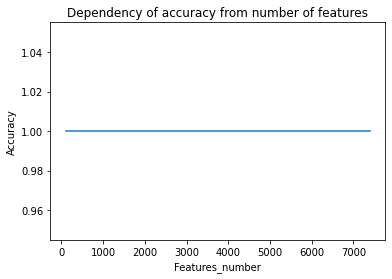

In [54]:
features_numbers = []
accuracy_values = []
for i in range(100, 7500, 100):
    local_features_to_use = features[:i]
    local_model = Classifier()
    local_model.fit(train_df, local_features_to_use, "class")
    local_predicted_classes = local_model.predict(test_df)
    local_acc = round(accuracy_score(real_classes, local_predicted_classes), 3)
    features_numbers.append(i)
    accuracy_values.append(local_acc)

plt.plot(features_numbers, accuracy_values)
plt.title("Dependency of accuracy from number of features")
plt.xlabel("Features_number")
plt.ylabel("Accuracy")

Demonstrate some images

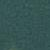

In [55]:
Image(filename=f"{data_dir}/water.jpg")

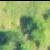

In [58]:
Image(filename=f"{data_dir}/field.jpg")

# Висновок

У даному завданні були взяті два різні види зображення(вода та поле). Ці дані були перетворені на вектори
фіч та розподілені на вибірки для тренування та навчання. Для навчання використовувався метод потенційних функцій. Модель вказаного программного класу була навчена методом ```fit```. Для класифікації був використаний метод ```predict``` із вказаного программного класу. Модель показала точність 100%. Далі були проведені тести стосовно побудови моделей, що навчаються за різною кількістю ознак.
Як видно із малюнку графіку точність у вказаному тесті становить 100 відсотків не залежно від кількості ознак. Дана аномалія можлива через невеликий об'єм тренувальних та тестових даних, а також через велику розмірність.